In [73]:
import os
import pathlib
import wave
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import seaborn as sns

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

print(tf.__version__)

2.11.0


In [4]:
# Download dataset.
DATASET_PATH = 'data/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
    tf.keras.utils.get_file(
        'mini_speech_commands.zip',
        origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
        extract=True,
        cache_dir='.', cache_subdir='data')

In [5]:
# Get commands from dataset.
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands !=  'README.md']
print(f'Commands: {commands}')

Commands: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


In [7]:
# New TF 2.10 util for audio clips
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')

label_names = np.array(train_ds.class_names)
print(f'\nlabel names: {label_names}')

Found 8000 files belonging to 8 classes.
Using 6400 files for training.
Using 1600 files for validation.

label names: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


In [8]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [10]:
# The audio in the dataset is single channel, so we can drop the last axis.
def squeeze(audio, labels):
    audio = tf.squeeze(audio, axis=-1)
    return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [11]:
# Split the val_ds into a test_ds, also.
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [12]:
# take() returns a feature and label as a tuple.
for example_audio, example_labels in train_ds.take(1):
    print(example_audio.shape)
    print(example_labels.shape)

(64, 16000)
(64,)


In [13]:
# Test label_names.
label_names[[1,1,3,0]]

array(['go', 'go', 'no', 'down'], dtype='<U5')

In [15]:
# Compute spectrogram of any raw waveform.
def get_spectrogram(waveform):
    spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    # Add flat channel axis so you can use convolution on this data.
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram

In [17]:
# Display some test data.
for i in range(3):
    label = label_names[example_labels[i]]
    waveform = example_audio[i]
    spectrogram = get_spectrogram(waveform)
    
    print(f"Label: {label}")
    print(f"Waveform shape: {waveform.shape}")
    print(f"Spectrogram shape: {spectrogram.shape}")
    print(f"Audio playback")
    display.display(display.Audio(waveform, rate=16000))

Label: go
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: no
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: left
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


In [19]:
# Visualize spectrogram.
def plot_spectrogram(spectrogram, ax):
    # Ensure the correct shape of spectrogram. If not correct shape modify it.
    if len(spectrogram.shape) > 2:
        assert len(spectrogram.shape) == 3
        spectrogram = np.squeeze(spectrogram, axis=-1)
    
    # Take log of spectrogram to visualize better. Add 'epsilon' so log of 0 is never taken.
    log_spec = np.log(spectrogram.T + np.finfo(float).eps)
    height = log_spec.shape[0]
    widght = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=widght, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)

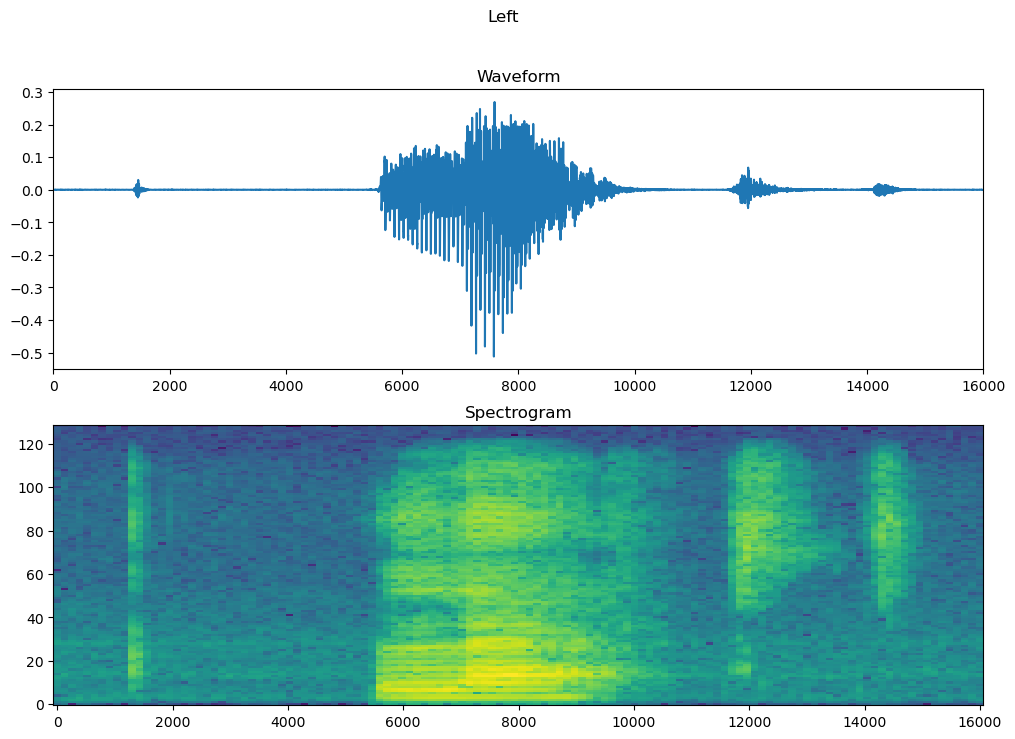

In [24]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])

plot_spectrogram(spectrogram.numpy(), axes[1])

axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

In [25]:
# Create spectrogram dataset from an audio dataset.
def make_spec_ds(ds):
    return ds.map(
        map_func=lambda audio, label: (get_spectrogram(audio), label),
        num_parallel_calls=tf.data.AUTOTUNE
    )

In [26]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [27]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
    break

In [28]:
# Build and train model using CNN, which works well on 2D data, like spectrograms.
input_shape = example_spectrograms.shape[1:]
print(f"Input shape: {input_shape}")
num_labels = len(commands)

# https://www.tensorflow.org/api_docs/python/tf/keras/layers/Normalization
# Normalization layers should always be adapted over a dataset, or manually passed
# mean and variance arguments.
norm_layer = layers.Normalization()
# Map to the spectrogram data of the dataset.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample input. Model trains faster on smaller images.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    # Dropout layers randomly set input units to 0 at a specified rate at
    # each step during training time. This helps prevent overfitting.
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])
model.summary()

Input shape: (124, 129, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           

In [29]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [34]:
# Reset Weights and Biases of model for retraining.
for i, layer in enumerate(model.layers):
    if hasattr(model.layers[i], 'kernel_initializer') and \
            hasattr(model.layers[i], 'bias_initializer'):
        weight_initializer = model.layers[i].kernel_initializer
        bias_initializer = model.layers[i].bias_initializer
        
        old_weights, old_biases = model.layers[i].get_weights()
        
        model.layers[i].set_weights([
            weight_initializer(shape=old_weights.shape),
            bias_initializer(shape=old_biases.shape)
        ])

In [35]:
EPOCHS = 25
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    # Stop training after 2 epochs of no improvement.
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/25
100/100 [==============================] - 17s 166ms/step - loss: 1.7477 - accuracy: 0.3628 - val_loss: 1.2595 - val_accuracy: 0.6198
Epoch 2/25
100/100 [==============================] - 16s 155ms/step - loss: 1.1897 - accuracy: 0.5684 - val_loss: 0.9140 - val_accuracy: 0.7409
Epoch 3/25
100/100 [==============================] - 18s 174ms/step - loss: 0.9279 - accuracy: 0.6711 - val_loss: 0.7583 - val_accuracy: 0.7682
Epoch 4/25
100/100 [==============================] - 16s 158ms/step - loss: 0.7648 - accuracy: 0.7180 - val_loss: 0.6731 - val_accuracy: 0.7878
Epoch 5/25
100/100 [==============================] - 16s 160ms/step - loss: 0.6542 - accuracy: 0.7669 - val_loss: 0.5875 - val_accuracy: 0.8346
Epoch 6/25
100/100 [==============================] - 17s 162ms/step - loss: 0.5665 - accuracy: 0.7961 - val_loss: 0.5600 - val_accuracy: 0.8255
Epoch 7/25
100/100 [==============================] - 17s 163ms/step - loss: 0.5108 - accuracy: 0.8175 - val_loss: 0.5381 - val_ac

Text(0, 0.5, 'Accuracy [%]')

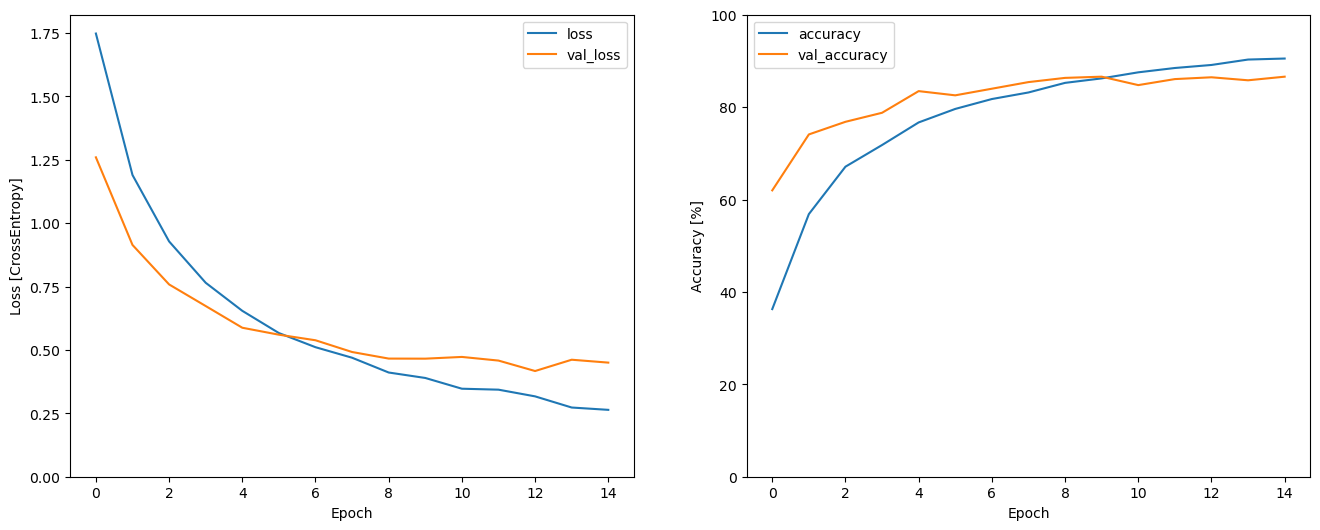

In [36]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

In [37]:
# Run the model on the testing dataset.
model.evaluate(test_spectrogram_ds, return_dict=True)

13/13 [==============================] - 2s 78ms/step - loss: 0.4823 - accuracy: 0.8474


{'loss': 0.4823229908943176, 'accuracy': 0.8473557829856873}

In [38]:
# Build confusion matrix.
y_pred = model.predict(test_spectrogram_ds)

13/13 [==============================] - 2s 90ms/step


In [39]:
y_pred = tf.argmax(y_pred, axis=1)

In [40]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s, lab: lab)), axis=0)

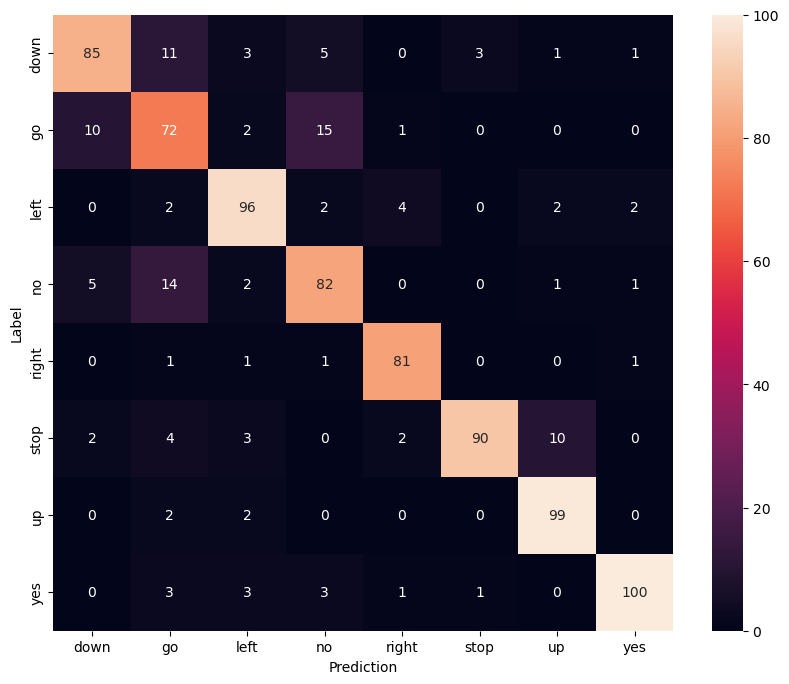

In [41]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

no


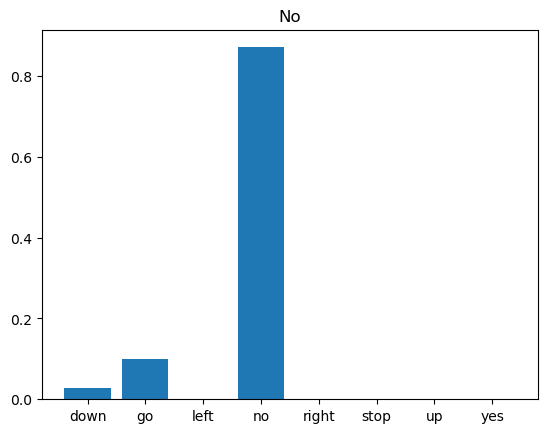

In [64]:
# Observe prediction output for some test audio.
x = data_dir/'no/01bb6a2a_nohash_0.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis, ...]

prediction = model(x)
label_pred = np.argmax(prediction, axis=1)
print(commands[label_pred[0]])
plt.bar(commands, tf.nn.softmax(prediction[0]))
plt.title('No')
plt.show()

display.display(display.Audio(waveform, rate=16000))

In [70]:
sample_file = 'data/mini_speech_commands/no/01bb6a2a_nohash_0.wav'

obj = wave.open(sample_file, 'rb')
n_samples = obj.getnframes()
signal_wave = obj.readframes(n_samples)
signal_array = np.frombuffer(signal_wave, dtype=np.int16)
obj.close()

print(signal_array.shape)

(16000,)


In [75]:
model.save('saved_model')

INFO:tensorflow:Assets written to: saved_model\assets


INFO:tensorflow:Assets written to: saved_model\assets


In [77]:
loaded_model = models.load_model('saved_model')

In [81]:
# Observe the output is the same using a numpy array, validating we can use the model like this.
waveform = signal_array / 32768
waveform = tf.convert_to_tensor(waveform, dtype=tf.float32)

spec = get_spectrogram(waveform)
spec = tf.expand_dims(spec, 0)
prediction = loaded_model(spec)
print(prediction)

tf.Tensor(
[[ 1.6791782  2.929602  -3.5944414  5.098144  -4.441216  -3.145519
  -4.362302  -2.2596989]], shape=(1, 8), dtype=float32)
